<a href="https://colab.research.google.com/github/aparna993/Customer-Cohort-Analysis/blob/master/cohort.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from operator import attrgetter
import matplotlib.colors as mcolors

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
df = pd.read_excel('/online_retail_II.xlsx',
                   dtype={'CustomerID': str,
                          'InvoiceID': str},
                   parse_dates=['InvoiceDate'], 
                   infer_datetime_format=True)

df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525461 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      525461 non-null  object        
 1   StockCode    525461 non-null  object        
 2   Description  522533 non-null  object        
 3   Quantity     525461 non-null  int64         
 4   InvoiceDate  525461 non-null  datetime64[ns]
 5   Price        525461 non-null  float64       
 6   Customer ID  417534 non-null  float64       
 7   Country      525461 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.1+ MB


In [6]:
df.dropna(subset=['Customer ID'], inplace=True)

In [7]:
df[["Quantity","Price"]].describe()

,Quantity,Price
count,417534.000000,417534.000000
mean,12.758815,3.887547
std,101.220424,71.131797
min,-9360.000000,0.000000
25%,2.000000,1.250000
50%,4.000000,1.950000
75%,12.000000,3.750000
max,19152.000000,25111.090000


In [8]:
(df['Quantity'] < 0).sum()

9839

In [9]:
df_new = (df[df['Quantity']<0])
df = df.drop(df_new.index)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407695 entries, 0 to 525460
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   Invoice      407695 non-null  object        
 1   StockCode    407695 non-null  object        
 2   Description  407695 non-null  object        
 3   Quantity     407695 non-null  int64         
 4   InvoiceDate  407695 non-null  datetime64[ns]
 5   Price        407695 non-null  float64       
 6   Customer ID  407695 non-null  float64       
 7   Country      407695 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 28.0+ MB


In [11]:
unique_orders_perc = df.groupby(["Customer ID"])["Invoice"].nunique()

In [12]:
multi_orders_perc = np.sum(unique_orders_perc>1)/df['Customer ID'].nunique()

In [13]:
print(f'{100* multi_orders_perc:.2f}% of customers ordered more than once')

67.06% of customers ordered more than once


[Text(0, 0.5, 'Number of customers'),
 Text(0.5, 0, 'Number of orders'),
 Text(0.5, 1.0, 'Distribution of number of orders per customer')]

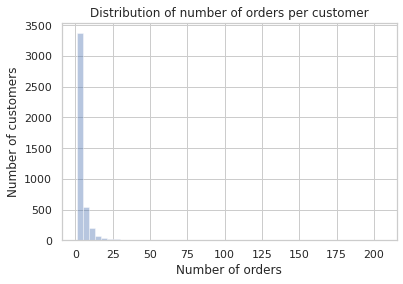

In [14]:
ax = sns.distplot(unique_orders_perc,kde = False,hist = True)
ax.set(title = 'Distribution of number of orders per customer',
       xlabel= 'Number of orders',
       ylabel = 'Number of customers')

In [23]:
df_cohort = df[['Customer ID','Invoice','InvoiceDate']].drop_duplicates()

In [27]:
df['order_month'] = df['InvoiceDate'].dt.to_period('M')
df['cohort'] = df.groupby('Customer ID')['InvoiceDate'] \
                 .transform('min') \
                 .dt.to_period('M') 
df_cohort = df.groupby(['cohort', 'order_month']) \
              .agg(n_customers=('Customer ID', 'nunique')) \
              .reset_index(drop=False)
df_cohort['period_number'] = (df_cohort.order_month - df_cohort.cohort).apply(attrgetter('n'))
cohort_pivot = df_cohort.pivot_table(index = 'cohort',
                                     columns = 'period_number',
                                     values = 'n_customers')


[]

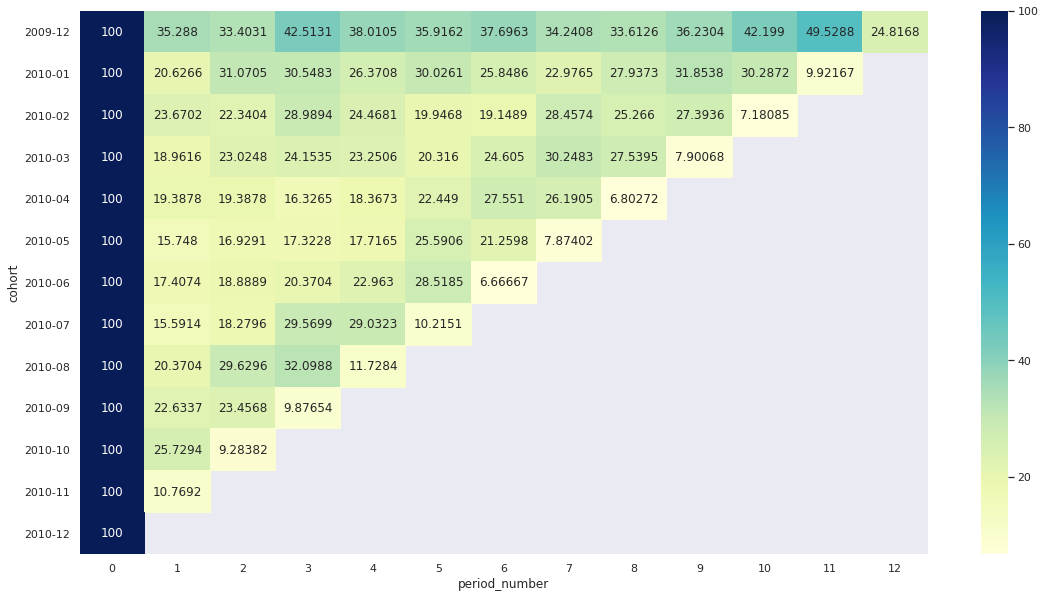

In [63]:
cohort_size = cohort_pivot.iloc[:,0]
retention_matrix = cohort_pivot.divide(cohort_size, axis = 0)
sns.set(rc={'figure.figsize':(19,10)})
sns.heatmap(retention_matrix*100,annot = True,cmap="YlGnBu",fmt = 'g')
ax.set()

period_number,0,1,2,3,4,5,6,7,8,9,10,11,12
cohort,,,,,,,,,,,,,
2009-12,100.0,35.287958,33.403141,42.513089,38.010471,35.916230,37.696335,34.240838,33.612565,36.230366,42.198953,49.528796,24.816754
2010-01,100.0,20.626632,31.070496,30.548303,26.370757,30.026110,25.848564,22.976501,27.937337,31.853786,30.287206,9.921671,NaN
2010-02,100.0,23.670213,22.340426,28.989362,24.468085,19.946809,19.148936,28.457447,25.265957,27.393617,7.180851,NaN,NaN
2010-03,100.0,18.961625,23.024831,24.153499,23.250564,20.316027,24.604966,30.248307,27.539503,7.900677,NaN,NaN,NaN
2010-04,100.0,19.387755,19.387755,16.326531,18.367347,22.448980,27.551020,26.190476,6.802721,NaN,NaN,NaN,NaN
2010-05,100.0,15.748031,16.929134,17.322835,17.716535,25.590551,21.259843,7.874016,NaN,NaN,NaN,NaN,NaN
2010-06,100.0,17.407407,18.888889,20.370370,22.962963,28.518519,6.666667,NaN,NaN,NaN,NaN,NaN,NaN
2010-07,100.0,15.591398,18.279570,29.569892,29.032258,10.215054,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-08,100.0,20.370370,29.629630,32.098765,11.728395,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
